## Cam Analysis

Here are some analysis of CAM, including position analysis and amino acid analysis.

In [2]:
import os
import sys
import argparse
sys.path.append("/mnt/8t/jjr/Structural-DPP-IV")

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# from model import StructuralDPPIV
from config import load_config
from config.load_constant import constant
from data import StructuralEncode
from data import Encode
from util import util_draw

config_dict = load_config.load_default_args_dict("StructuralDPPIV")
config_dict['max_epochs'] = 150
config_dict['gpus'] = [3]  # using which GPU to train
config_dict['batch_size'] = 32
config_dict['lr'] = 0.000005
config_dict['model'] = 'StructuralDPPIV'
config_dict['log_dir'] = constant['path_log']
config_dict['max_seq_len'] = 90
args = argparse.Namespace(**config_dict)

class StructuralDPPIV(nn.Module):
    def __init__(self, config):
        super(StructuralDPPIV, self).__init__()
        self.StructEncodeModule = Structural(config)
        self.TextCNN = TextCNN()

        self.classification = nn.Sequential(
            nn.Linear(1024, 64),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(64, 2)
        )
        self.Ws = nn.Parameter(torch.randn(1, 1024).cuda(), requires_grad=True)
        self.Wh = nn.Parameter(torch.randn(1, 1024).cuda(), requires_grad=True)

        self.sequence_code = None

    def set_sequence_code(self, sequence_code):
        self.sequence_code = sequence_code

    def forward(self, x):
        TextCNN_Only = False
        StructuralEncodingOnly = False
        assert not (TextCNN_Only and StructuralEncodingOnly)
        if not TextCNN_Only and not StructuralEncodingOnly:
            TextCNNEncode = self.TextCNN(self.sequence_code)
            StructedEncode = self.StructEncodeModule(x)
            newEncode = TextCNNEncode * StructedEncode
            output = self.classification(newEncode)
            return output
        elif TextCNN_Only:
            TextCNNEncode = self.TextCNN(self.sequence_code)
            output = self.classification(TextCNNEncode)
            return output
        elif StructuralEncodingOnly:
            StructedEncode = self.StructEncodeModule(x)
            output = self.classification(StructedEncode)
            return output


class TextCNN(nn.Module):
    def __init__(self):
        super(TextCNN, self).__init__()
        self.visualization = False
        vocab_size = 24
        dim_embedding = 100
        # print(f"[INFO] using CNN config of {dataset_name}")
        # filter_sizes = [1, 2, 4, 8, 16, 24, 32, 48, 64]
        filter_sizes = [1, 2]
        filter_num = 90
        self.embedding = nn.Embedding(vocab_size, dim_embedding)
        self.convs = nn.ModuleList(
            [nn.Conv2d(1, filter_num, (fsz, dim_embedding)) for fsz in filter_sizes])
        self.linear = nn.Linear(filter_num * len(filter_sizes), 1024)

    def forward(self, x):
        # print("\nx = \n", x)
        x = self.embedding(x)
        x = x.view(x.size(0), 1, x.size(1), -1)
        x = [F.relu(conv(x)) for conv in self.convs]

        x = [F.max_pool2d(input=x_item, kernel_size=(x_item.size(2), x_item.size(3))) for x_item in x]
        x = [x_item.view(x_item.size(0), -1) for x_item in x]
        embedding = torch.cat(x, 1)
        embedding = self.linear(embedding)

        return embedding


class Structural(nn.Module):
    def __init__(self, config):
        super(Structural, self).__init__()
        self.config = config
        self.inpuchannel = [32, 32, 64]
        global dataset_name
        dataset_name = 'DPP-IV'
        # print(f"[INFO] using Structural config of {dataset_name}")
        self.embedding_dim = 21
        global max_seq_len
        max_seq_len = config.max_seq_len
        self.conv = torch.nn.Conv2d(self.embedding_dim, self.inpuchannel[0], (3, 3), stride=1, padding='same')
        # self.conv = torch.nn.Conv2d(19, self.inpuchannel[0], (3, 3), stride=1, padding='same')
        self.resBlock1 = resBlock(self.inpuchannel[0], self.inpuchannel[1])
        self.resBlock2 = resBlock(self.inpuchannel[1], self.inpuchannel[2], increDimen=True)
        self.linear = nn.Linear(23552, 1024)

    def forward(self, graph):
        # 90 is the max length of sequence, 15 is the number of amino acid, 21 is the number of channel
        graph = graph.cuda()  # (batchSize, 90, 15, 21)
        # graph = graph.transpose(2, 3)  # (batchSize, 90, 21, 15)
        # graph = graph.transpose(1, 2)   # (batchSize, 21, 90, 15)
        representation = self.conv(graph) # (batchSize, 32, 90, 15)
        representation = self.resBlock1(representation) # (batchSize, 32, 90, 15)
        representation = self.resBlock2(representation) # (batchSize, 64, 46, 8)
        representation = representation.flatten(start_dim=1) # (batchSize, 23552)
        representation = self.linear(representation) # (batchSize, 1024)
        return representation


class resBlock(nn.Module):
    def __init__(self, inputchannel, outputchannel, increDimen=False):
        super(resBlock, self).__init__()
        self.increDimen = increDimen
        self.inputchannel = inputchannel
        self.outputchannel = outputchannel
        padding_dim1 = 2 if max_seq_len % 2 == 0 else 1
        self.conv = torch.nn.Conv2d(inputchannel, outputchannel, (3, 3), stride=(2, 2), padding=(padding_dim1, 1))
        self.conv1 = torch.nn.Conv2d(inputchannel, outputchannel, (3, 3), stride=1, padding='same')
        self.batchnorm1 = nn.BatchNorm2d(inputchannel, affine=True)
        self.conv2 = torch.nn.Conv2d(outputchannel, outputchannel, (3, 3), stride=1, padding='same')
        self.batchnorm2 = nn.BatchNorm2d(outputchannel, affine=True)

    def forward(self, feature):
        original = feature

        if self.increDimen:
            feature = F.max_pool2d(input=feature, kernel_size=(2, 2), padding=1)
            original = self.conv(original)
        feature = self.batchnorm1(feature)
        feature = F.relu(feature)
        feature = self.conv1(feature)
        feature = self.batchnorm2(feature)
        feature = F.relu(feature)
        feature = self.conv2(feature)
        feature = feature + original
        return feature


def load_params(model, param_path):
    pretrained_dict = torch.load(param_path)['state_dict']
    # print(pretrained_dict.keys())
    new_model_dict = model.state_dict()
    # print(new_model_dict.keys())
    pretrained_dict = {'.'.join(k.split('.')[1:]): v for k, v in pretrained_dict.items() if '.'.join(k.split('.')[1:]) in new_model_dict}
    # pretrained_dict = {k[6:]: v for k, v in pretrained_dict.items() if k[6:] in new_model_dict}
    # print(pretrained_dict.keys())
    new_model_dict.update(pretrained_dict)
    model.load_state_dict(new_model_dict)

def get_one_sequence_code(sequence = 'YPFPGPIP'):
    # sequence = 'YPFPGPIP'
    Channel = StructuralEncode.convert_to_graph_channel(sequence)
    Structure_data = StructuralEncode.convert_to_graph_channel_returning_maxSeqLenx15xfn(Channel, cubeBiased=False,
                                                                 maxSeqLen=90, cubeBias=False,
                                                                 right_align=False)
    tensor_Structure_data = torch.tensor(Structure_data).cuda()
    tensor_Structure_data = torch.unsqueeze(tensor_Structure_data, 0)
    tensor_Structure_data = tensor_Structure_data.transpose(2, 3)  # (batchSize, 90, 21, 15)
    tensor_Structure_data = tensor_Structure_data.transpose(1, 2)   # (batchSize, 21, 90, 15)

    sequence_data_process = Encode.codePeptides([sequence])
    sequence_data_length = len(sequence_data_process[0])
    sequence_data_padding = np.pad(sequence_data_process[0], (0, 90 - sequence_data_length), 'constant', constant_values=0)
    sequence_data = torch.tensor(np.array([sequence_data_padding])).cuda()

    # print(sequence_data)
    return [sequence_data, tensor_Structure_data]


new_model = StructuralDPPIV(args).cuda()
load_params(new_model, '/mnt/8t/jjr/Structural-DPP-IV/main/log/StructuralDPPIV/version_3/checkpoints/epoch=73,step=2442,val_SE_epoch=0.95,val_SP_epoch=0.87,val_F1_epoch=0.91,val_AUC_epoch=1.00.ckpt')
# load_params(new_model, '/mnt/8t/jjr/Structural-DPP-IV/main/log/StructuralDPPIV/version_4/checkpoints/epoch=60,step=2013,val_SE_epoch=0.97,val_SP_epoch=0.81,val_F1_epoch=0.90,val_AUC_epoch=1.00.ckpt')
new_model.eval()

/mnt/8t/jjr/Structural-DPP-IV


StructuralDPPIV(
  (StructEncodeModule): Structural(
    (conv): Conv2d(21, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (resBlock1): resBlock(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(2, 1))
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (resBlock2): resBlock(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(2, 1))
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (batchnorm2): BatchNorm2d(64,

In [3]:
def load_tsv(filename, skip_head=True):
    sequences = []
    labels = []
    with open(filename, 'r') as file:
        if skip_head:
            next(file)
        for line in file:
            if line[-1] == '\n':
                line = line[:-1]
            list = line.split('\t')
            sequences.append(list[2])
            labels.append(int(list[1]))
    return sequences, labels

pred_prob = []
label_pred = []
predict_true = 0

sequences, labels = load_tsv('/mnt/8t/jjr/Structural-DPP-IV/data/DPP-IV/test/test.tsv')
# sequences, labels = load_tsv('/mnt/8t/jjr/Structural-DPP-IV/data/DPP-IV/train/train.tsv')
from tqdm import tqdm
# predict sequence one by one
for index in tqdm(range(len(sequences))):
    # print("before success2:", config.learn_name)
    [sequence_code, structual_code] = get_one_sequence_code(sequences[index])
    new_model.set_sequence_code(sequence_code)
    logits = new_model(structual_code)

    pred_prob_all = F.softmax(logits, dim=1)  # predict probability [batch_size, class_num]
    pred_prob_positive = pred_prob_all[:, 1]  # note, it is very easy to make mistake
    pred_prob_sort = torch.max(pred_prob_all, 1)  # max probability in each sample [batch_size]
    pred_class = pred_prob_sort[1]  # where max probability site in each sample [batch_size]

    pred_prob = pred_prob + pred_prob_positive.tolist()
    label_pred = label_pred + pred_class.tolist()

acc = accuracy_score(labels, label_pred)
auc = roc_auc_score(labels, pred_prob)
f1 = f1_score(labels, label_pred)
se = recall_score(labels, label_pred)
sp = recall_score(labels, label_pred, pos_label=0)

print('acc:', acc)
print('auc:', auc)
print('f1:', f1)
print('se:', se)
print('sp:', sp)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 266/266 [00:06<00:00, 39.04it/s]

acc: 0.9097744360902256
auc: 0.9657414212222284
f1: 0.9130434782608695
se: 0.9473684210526315
sp: 0.8721804511278195


# 2. Import pytorch_grad_cam and make adjustment

In [1]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, LayerCAM
from util import util_draw
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
class ClassificationTarget:
    def __init__(self,target_category):
        self.target_category = target_category
        self.loss_fun = torch.nn.CrossEntropyLoss()

    def __call__(self, model_output):
        # print(model_output)
        loss = self.loss_fun(model_output, torch.tensor(self.target_category).cuda())
        return loss


ModuleNotFoundError: No module named 'pytorch_grad_cam'

In [5]:
sequence = 'YPFPGPIP'
new_model.eval()
[sequence_code, structual_code] = get_one_sequence_code(sequence)
new_model.set_sequence_code(sequence_code)
logits = new_model(structual_code)
pred_prob_all = F.softmax(logits, dim=1)  # predict probability [batch_size, class_num]
print(pred_prob_all)

loss = torch.nn.CrossEntropyLoss()(logits, torch.tensor([1]).cuda())
print(loss)

ClassificationTarget(1)(logits[0])

tensor([[0.1130, 0.8870]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor(0.1199, device='cuda:0', grad_fn=<NllLossBackward0>)


tensor(0.1199, device='cuda:0', grad_fn=<NllLossBackward0>)

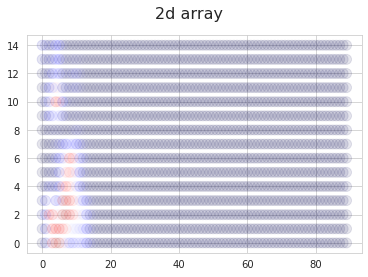

In [6]:
# Targets = [ClassificationTarget(0)]
Targets = [ClassificationTarget(1)]
target_layers = [new_model.StructEncodeModule.resBlock2]
[sequence_code, structual_code] = get_one_sequence_code("YPFPGPIP")

with GradCAMPlusPlus(model=new_model,
             target_layers=target_layers,
             use_cuda=True) as cam:
    new_model.set_sequence_code(sequence_code)
    grayscale_cam = cam(input_tensor=structual_code,
                        targets=Targets)


util_draw.plot_2d_array(grayscale_cam[0])

In [7]:
def get_one_sequence_cam(sequence, cam_type, class_type, plot_flag=False, target_layers=[new_model.StructEncodeModule.resBlock2]):
    Targets = [ClassificationTarget(class_type)]
    target_layers = target_layers
    [sequence_code, structual_code] = get_one_sequence_code(sequence)
    if cam_type == 'GradCAM':
        CAM = GradCAM
    elif cam_type == 'ScoreCAM':
        CAM = ScoreCAM
    elif cam_type == 'GradCAM++':
        CAM = GradCAMPlusPlus
    elif cam_type == 'AblationCAM':
        CAM = AblationCAM
    elif cam_type == 'XGradCAM':
        CAM = XGradCAM
    elif cam_type == 'LayerCAM':
        CAM = LayerCAM
    else:
        print('cam_type error')
        return
    with CAM(model=new_model,
                 target_layers=target_layers,
                 use_cuda=True) as cam:
        new_model.set_sequence_code(sequence_code)
        grayscale_cam = cam(input_tensor=structual_code,
                            targets=Targets)
    if plot_flag:
        util_draw.plot_2d_array(grayscale_cam[0], cam_type)
    return grayscale_cam[0]

In [ ]:
CAM_type = ['GradCAM', 'ScoreCAM', 'GradCAM++', 'AblationCAM', 'XGradCAM', 'LayerCAM']
class_type = 1
plot_flag = True
target_layers = [new_model.StructEncodeModule.resBlock2]
sequence = 'YPFPGPIP'

for cam_type in CAM_type:
    get_one_sequence_cam(sequence, cam_type, class_type, plot_flag, target_layers)

# 3.1 position analysis

In [10]:
# basic count of each site score
def position_analysis_base(sequences, cam_type, class_type, plot_flag=False, target_layers=[new_model.StructEncodeModule.resBlock2]):
    position_score = [0 for i in range(90)]
    for sequence in sequences:
        grayscale_cam = get_one_sequence_cam(sequence, cam_type, class_type, plot_flag, target_layers)
        position_score = position_score + np.sum(grayscale_cam, axis=1)
    return position_score

In [11]:
# compute average score on each site
def position_analysis_plus(sequences, cam_type, class_type, plot_flag=False, target_layers=[new_model.StructEncodeModule.resBlock2]):
    position_scores = [[] for i in range(90)]
    position_count = [0 for i in range(90)]
    for sequence in sequences:
        grayscale_cam = get_one_sequence_cam(sequence, cam_type, class_type, plot_flag, target_layers)
        position_score = np.sum(grayscale_cam, axis=1)
        for i in range(len(sequence)):
            position_scores[i].append(position_score[i])
            position_count[i] = position_count[i] + 1
    position_score = [sum(position) for position in position_scores]
    for i in range(len(position_score)):
        position_score[i] = position_score[i] / position_count[i]
    return position_score, position_count

In [15]:
import math
# compute average score on each site and add position fix (use log function)
def position_analysis_plus_plus(sequences, cam_type, class_type, plot_flag=False, target_layers=[new_model.StructEncodeModule.resBlock2]):
    position_scores = [[] for i in range(90)]
    position_counts = [0 for i in range(90)]
    for sequence in sequences:
        grayscale_cam = get_one_sequence_cam(sequence, cam_type, class_type, plot_flag, target_layers)
        position_score = np.sum(grayscale_cam, axis=1)
        for i in range(len(sequence)):
            position_scores[i].append(position_score[i])
            position_counts[i] = position_counts[i] + 1
    position_score = [sum(position) if len(position) > 0 else 0.0 for position in position_scores]
    position_count = [math.log(count + 1) for count in position_counts]
    # position_count = [count for count in position_counts]
    for i in range(len(position_score)):
        if position_count[i] > 0:
            position_score[i] = position_score[i] / (position_count[i])
        else:
            position_score[i] = 0.0
        # position_score[i] = position_score[i] / position_counts[i]
    return position_score, position_counts


In [ ]:
pos_position_score, pos_position_count = position_analysis_plus_plus(sequences[:labels.index(0)], 'ScoreCAM', 1, plot_flag=False, target_layers=[new_model.StructEncodeModule.resBlock2])
neg_position_score, neg_position_count = position_analysis_plus_plus(sequences[labels.index(0):], 'ScoreCAM', 1, plot_flag=False, target_layers=[new_model.StructEncodeModule.resBlock2])

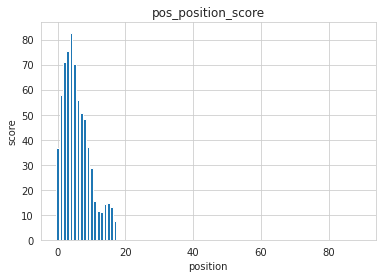

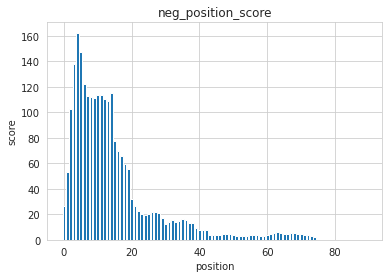

In [19]:
from util import util_draw
util_draw.plot_bar([i for i in range(90)], pos_position_score, 'pos_position_score', 'position', 'score')
util_draw.plot_bar([i for i in range(90)], neg_position_score, 'neg_position_score', 'position', 'score')

# 3.2 amino_acid_analysis

In [20]:
aa_dict = {'A': 1, 'R': 2, 'N': 3, 'D': 4, 'C': 5, 'Q': 6, 'E': 7, 'G': 8, 'H': 9, 'I': 10,
           'L': 11, 'K': 12, 'M': 13, 'F': 14, 'P': 15, 'S': 16, 'T': 17,
           'W': 18, 'Y': 19, 'V': 20}
aa_list = list(aa_dict.keys())
amino_acid_atom_count = [6, 12, 9, 9, 7, 10, 10, 5, 11, 9, 9, 10, 9, 12, 8, 7, 8, 15, 13, 8]

In [22]:
# V1 compute the whole atom list
def amino_acid_analysis_V1(sequences, cam_type, class_type, plot_flag=False, target_layers=[new_model.StructEncodeModule.resBlock2]):
    amino_acid_score = [0 for i in range(len(aa_list))]

    for sequence in sequences:
        grayscale_cam = get_one_sequence_cam(sequence, cam_type, class_type, plot_flag, target_layers)
        position_score = np.sum(grayscale_cam, axis=1)
        # print(position_score.shape)
        for i in range(len(sequence)):
            # print(sequence[i])
            # print(aa_dict[sequence[i]]-1)
            amino_acid_score[aa_dict[sequence[i]]-1] = amino_acid_score[aa_dict[sequence[i]]-1] + position_score[i]
        # position_score = position_score + np.sum(grayscale_cam, axis=1)
    return amino_acid_score

In [23]:
# V2 only compute the atom in one amino acid
def amino_acid_analysis_V2(sequences, cam_type, class_type, plot_flag=False, target_layers=[new_model.StructEncodeModule.resBlock2]):
    amino_acid_score = [0 for i in range(len(aa_list))]

    for sequence in sequences:
        grayscale_cam = get_one_sequence_cam(sequence, cam_type, class_type, plot_flag, target_layers)
        # position_score = np.sum(grayscale_cam, axis=1)
        # print(position_score.shape)
        for i in range(len(sequence)):
            # print(sequence[i])
            # print(aa_dict[sequence[i]]-1)
            amino_acid_score[aa_dict[sequence[i]]-1] = amino_acid_score[aa_dict[sequence[i]]-1] + np.sum(grayscale_cam[i][:amino_acid_atom_count[aa_dict[sequence[i]]-1]])
        # position_score = position_score + np.sum(grayscale_cam, axis=1)
    return amino_acid_score

In [24]:
class_type = 1

# 3.2.1 positive_sequences analysis

In [ ]:
pos_amino_acid_score = amino_acid_analysis_V2(sequences[:labels.index(0)], 'ScoreCAM', class_type, plot_flag=False, target_layers=[new_model.StructEncodeModule.resBlock2.conv2])

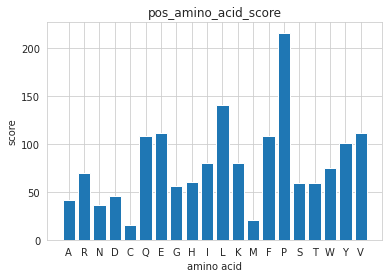

In [83]:
util_draw.plot_bar(aa_list, pos_amino_acid_score, 'pos_amino_acid_score', 'amino acid', 'score')

# 3.2.1.1 fix count amino_acid (V1)
add bias

In [43]:

amino_acid_count_pos = [0 for i in range(len(aa_list))]
for sequence in sequences[:labels.index(0)]:
    for i in range(len(sequence)):
        amino_acid_count_pos[aa_dict[sequence[i]]-1] = amino_acid_count_pos[aa_dict[sequence[i]]-1] + 1
        if i != 0:
            amino_acid_count_pos[aa_dict[sequence[i-1]]-1] = amino_acid_count_pos[aa_dict[sequence[i-1]]-1] + 1
        if i != len(sequence)-1:
            amino_acid_count_pos[aa_dict[sequence[i+1]]-1] = amino_acid_count_pos[aa_dict[sequence[i+1]]-1] + 1


amino_acid_count_pos_frequency = [0 for i in range(len(aa_list))]
for i in range(len(aa_list)):
    amino_acid_count_pos_frequency[i] = amino_acid_count_pos[i] / sum(amino_acid_count_pos)

# for i in range(len(aa_list)):
#     print(aa_list[i], amino_acid_count_pos[i], amino_acid_count_pos_frequency[i])
#     print(amino_acid_count_pos)
#     print(amino_acid_count_pos_frequency)

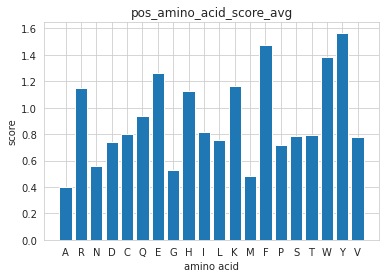

In [44]:
pos_amino_acid_score_avg = [0 for i in range(len(aa_list))]
for i in range(len(aa_list)):
    pos_amino_acid_score_avg[i] = pos_amino_acid_score[i] / amino_acid_count_pos[i]

util_draw.plot_bar(aa_list, pos_amino_acid_score_avg, 'pos_amino_acid_score_avg', 'amino acid', 'score')

# 3.2.1.2 fix count amino_acid (V2)
original amino_acid count

In [45]:
amino_acid_count_pos = [0 for i in range(len(aa_list))]
for sequence in sequences[:labels.index(0)]:
    for i in range(len(sequence)):
        amino_acid_count_pos[aa_dict[sequence[i]]-1] = amino_acid_count_pos[aa_dict[sequence[i]]-1] + 1

amino_acid_count_pos_frequency = [0 for i in range(len(aa_list))]
for i in range(len(aa_list)):
    amino_acid_count_pos_frequency[i] = amino_acid_count_pos[i] / sum(amino_acid_count_pos)

# for i in range(len(aa_list)):
#     print(aa_list[i], amino_acid_count_pos[i], amino_acid_count_pos_frequency[i])
#     print(amino_acid_count_pos)


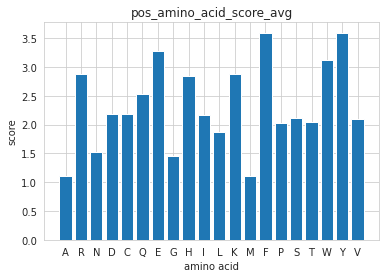

In [46]:
pos_amino_acid_score_avg = [0 for i in range(len(aa_list))]
for i in range(len(aa_list)):
    pos_amino_acid_score_avg[i] = pos_amino_acid_score[i] / amino_acid_count_pos[i]

util_draw.plot_bar(aa_list, pos_amino_acid_score_avg, 'pos_amino_acid_score_avg', 'amino acid', 'score')

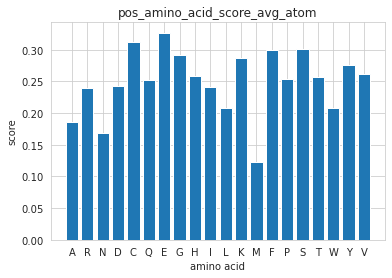

In [48]:
pos_amino_acid_score_avg_atom = [0 for i in range(len(aa_list))]
for i in range(len(aa_list)):
    pos_amino_acid_score_avg_atom[i] = pos_amino_acid_score_avg[i] / amino_acid_atom_count[i]
util_draw.plot_bar(aa_list, pos_amino_acid_score_avg_atom, 'pos_amino_acid_score_avg_atom', 'amino acid', 'score')

# 3.2.3 negative_sequences analysis

In [ ]:
neg_amino_acid_score = amino_acid_analysis_V2(sequences[labels.index(0):], 'ScoreCAM', class_type, plot_flag=False, target_layers=[new_model.StructEncodeModule.resBlock2.conv1])

In [54]:
amino_acid_count_neg = [0 for i in range(len(aa_list))]
for sequence in sequences[labels.index(0):]:
    for i in range(len(sequence)):
        amino_acid_count_neg[aa_dict[sequence[i]]-1] = amino_acid_count_neg[aa_dict[sequence[i]]-1] + 1

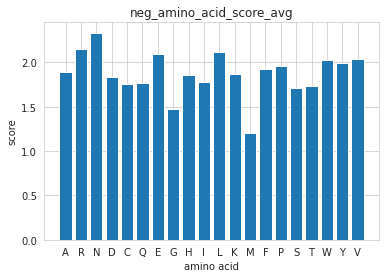

In [55]:
neg_amino_acid_score_avg = [0 for i in range(len(aa_list))]
for i in range(len(aa_list)):
    neg_amino_acid_score_avg[i] = neg_amino_acid_score[i] / amino_acid_count_neg[i]

util_draw.plot_bar(aa_list, neg_amino_acid_score_avg, 'neg_amino_acid_score_avg', 'amino acid', 'score')

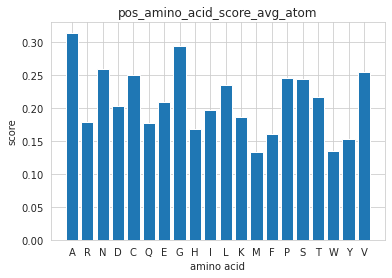

In [56]:
neg_amino_acid_score_avg_atom = [0 for i in range(len(aa_list))]
for i in range(len(aa_list)):
    neg_amino_acid_score_avg_atom[i] = neg_amino_acid_score_avg[i] / amino_acid_atom_count[i]
util_draw.plot_bar(aa_list, neg_amino_acid_score_avg_atom, 'pos_amino_acid_score_avg_atom', 'amino acid', 'score')

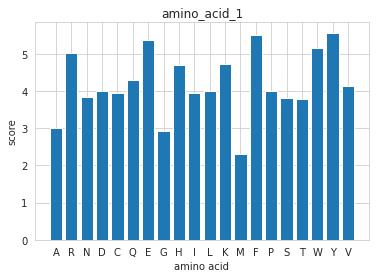

In [57]:
amino_acid_all = [0 for i in range(len(aa_list))]
for i in range(len(aa_list)):
    # amino_acid_1[i] = pos_amino_acid_score_avg_atom[i] + neg_amino_acid_score_avg_atom[i]
    amino_acid_all[i] = pos_amino_acid_score_avg[i] + neg_amino_acid_score_avg[i]
util_draw.plot_bar(aa_list, amino_acid_all, 'amino_acid_1', 'amino acid', 'score')

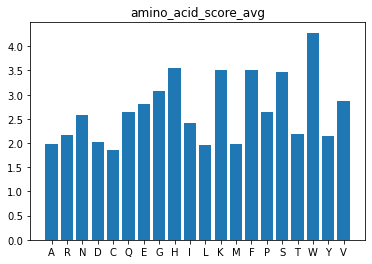

In [318]:
aa_k_fold_avg = [0 for i in range(len(aa_list))]
for i in range(len(aa_list)):
    aa_k_fold_avg[i] = pos_amino_acid_score_avg[i] / neg_amino_acid_score_avg[i]
util_draw.plot_bar(aa_list, aa_k_fold_avg, 'amino_acid_score_avg')

# 3.2.3 fix the bug of the amino_acid_analysis function
because of the cv.resize() function recount the amino acid score, so the amino_acid_analysis function should be modified.
For example, AXY sequence (90, 15), it will be convolution with the kernel, and the output will be (46, 8), so the amino acid .

# 3.3 Atom analysis

In [58]:
atom_list = ['C', 'N', 'O', 'S']
atom_dict = {'C': 1, 'N': 2, 'O': 3, 'S': 4}
aa_atom_dict = {
    'a': 'C[C@H]([NH2:1])[C:1](=[O:1])[O:1]',
    'c': '[NH2:1][C@@H](CS)[C:1](=[O:1])[O:1]',
    'd': '[NH2:1][C@@H](CC(=O)O)[C:1](=[O:1])[OH:1]',
    'e': '[NH2:1][C@@H](CCC(=O)O)[C:1](=[O:1])[OH:1]',
    'f': '[NH2:1][C@@H](Cc1ccccc1)[C:1](=[O:1])[OH:1]',
    'g': '[NH2:1]C[C:1](=[O:1])[OH:1]',
    'h': '[NH2:1][C@@H](Cc1c[nH]cn1)[C:1](=[O:1])[OH:1]',
    'i': 'CC[C@H](C)[C@H]([NH2:1])[C:1](=[O:1])[OH:1]',
    'k': 'NCCCC[C@H]([NH2:1])[C:1](=[O:1])[OH:1]',
    'l': 'CC(C)C[C@H]([NH2:1])[C:1](=[O:1])[OH:1]',
    'm': 'CSCC[C@H]([NH2:1])[C:1](=[O:1])[OH:1]',
    'n': 'NC(=O)C[C@H]([NH2:1])[C:1](=[O:1])[OH:1]',
    'p': '[O:1]=[C:1]([OH:1])[C@@H]1CCC[NH:1]1',
    'q': 'NC(=O)CC[C@H]([NH2:1])[C:1](=[O:1])[OH:1]',
    'r': 'N=C(N)NCCC[C@H]([NH2:1])[C:1](=[O:1])[OH:1]',
    's': '[NH2:1][C@@H](CO)[C:1](=[O:1])[OH:1]',
    't': 'C[C@@H](O)[C@H]([NH2:1])[C:1](=[O:1])[OH:1]',
    'v': 'CC(C)[C@H]([NH2:1])[C:1](=[O:1])[OH:1]',
    'w': '[NH2:1][C@@H](Cc1c[nH]c2ccccc12)[C:1](=[O:1])[OH:1]',
    'y': '[NH2:1][C@@H](Cc1ccc(O)cc1)[C:1](=[O:1])[OH:1]'
}  # SMILES in this dict had been processed.

In [59]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
IPythonConsole.ipython_useSVG=True  #< set this to False if you want PNGs instead of SVGs
def mol_with_atom_index(mol, atom_scores):
    for atom in mol.GetAtoms():
        # print(atom_scores[atom.GetIdx()])
        atom.SetAtomMapNum(int(atom_scores[atom.GetIdx()]))
    return mol

In [60]:
class_type = 1

In [61]:
def atom_analysis(sequences, cam_type, class_type, plot_flag, target_layers):
    amino_acid_atom_score = [[0 for i in range(15) ] for i in range(len(aa_list))]

    for sequence in sequences:
        grayscale_cam = get_one_sequence_cam(sequence, cam_type, class_type, plot_flag, target_layers)
        # position_score = np.sum(grayscale_cam, axis=1)
        # print(position_score.shape)
        for i in range(len(sequence)):
            # print(sequence[i])
            # print(aa_dict[sequence[i]]-1)
            for j in range(15):
                amino_acid_atom_score[aa_dict[sequence[i]]-1][j] = amino_acid_atom_score[aa_dict[sequence[i]]-1][j] + grayscale_cam[i][j]
            # amino_acid_atom_score[aa_dict[sequence[i]]-1] = amino_acid_score[aa_dict[sequence[i]]-1] + position_score[i]
        # position_score = position_score + np.sum(grayscale_cam, axis=1)
    return amino_acid_atom_score

In [ ]:
amino_acid_atom_score = atom_analysis(sequences, 'ScoreCAM', class_type, plot_flag=False, target_layers=[new_model.StructEncodeModule.resBlock2])

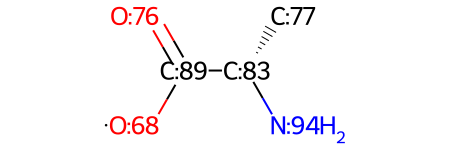

In [63]:
mol_with_atom_index(Chem.MolFromSmiles(aa_atom_dict['a']), amino_acid_atom_score[aa_dict['A']-1])

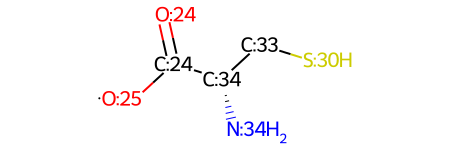

In [64]:
mol_with_atom_index(Chem.MolFromSmiles(aa_atom_dict['c']), amino_acid_atom_score[aa_dict['C']-1])

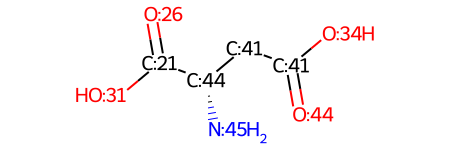

In [65]:
mol_with_atom_index(Chem.MolFromSmiles(aa_atom_dict['d']), amino_acid_atom_score[aa_dict['D']-1])

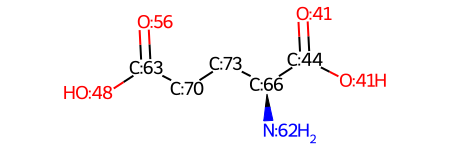

In [66]:
mol_with_atom_index(Chem.MolFromSmiles(aa_atom_dict['e']), amino_acid_atom_score[aa_dict['E']-1])

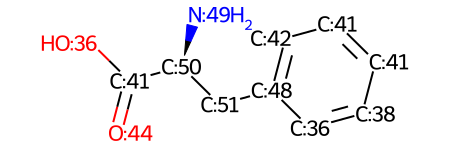

In [67]:
mol_with_atom_index(Chem.MolFromSmiles(aa_atom_dict['f']), amino_acid_atom_score[aa_dict['F']-1])

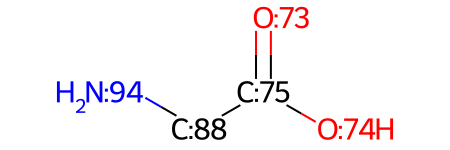

In [68]:
mol_with_atom_index(Chem.MolFromSmiles(aa_atom_dict['g']), amino_acid_atom_score[aa_dict['G']-1])

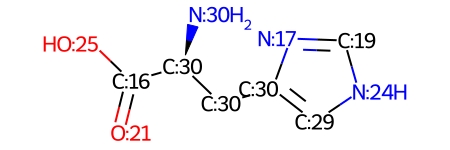

In [69]:
mol_with_atom_index(Chem.MolFromSmiles(aa_atom_dict['h']), amino_acid_atom_score[aa_dict['H']-1])

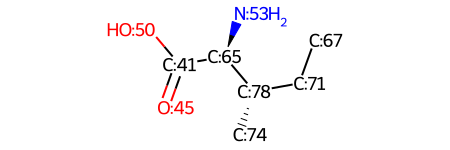

In [70]:
mol_with_atom_index(Chem.MolFromSmiles(aa_atom_dict['i']), amino_acid_atom_score[aa_dict['I']-1])

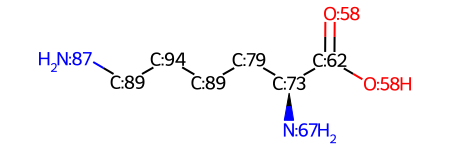

In [71]:
mol_with_atom_index(Chem.MolFromSmiles(aa_atom_dict['k']), amino_acid_atom_score[aa_dict['K']-1])

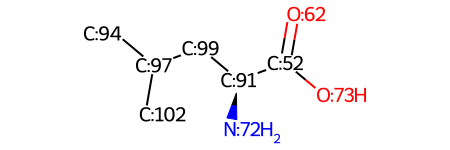

In [72]:
mol_with_atom_index(Chem.MolFromSmiles(aa_atom_dict['l']), amino_acid_atom_score[aa_dict['L']-1])

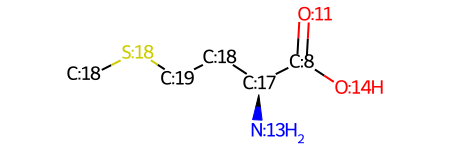

In [73]:
mol_with_atom_index(Chem.MolFromSmiles(aa_atom_dict['m']), amino_acid_atom_score[aa_dict['M']-1])

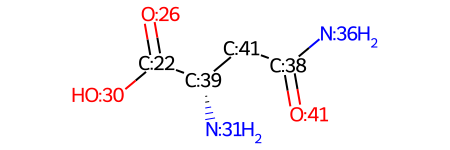

In [74]:
mol_with_atom_index(Chem.MolFromSmiles(aa_atom_dict['n']), amino_acid_atom_score[aa_dict['N']-1])

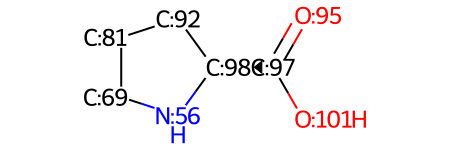

In [75]:
mol_with_atom_index(Chem.MolFromSmiles(aa_atom_dict['p']), amino_acid_atom_score[aa_dict['P']-1])

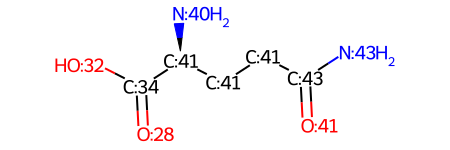

In [76]:
mol_with_atom_index(Chem.MolFromSmiles(aa_atom_dict['q']), amino_acid_atom_score[aa_dict['Q']-1])

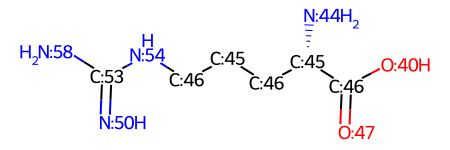

In [77]:
mol_with_atom_index(Chem.MolFromSmiles(aa_atom_dict['r']), amino_acid_atom_score[aa_dict['R']-1])

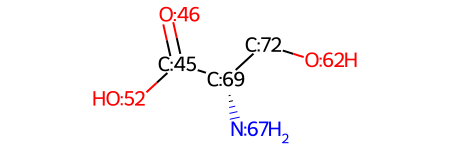

In [78]:
mol_with_atom_index(Chem.MolFromSmiles(aa_atom_dict['s']), amino_acid_atom_score[aa_dict['S']-1])

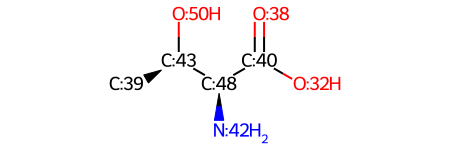

In [79]:
mol_with_atom_index(Chem.MolFromSmiles(aa_atom_dict['t']), amino_acid_atom_score[aa_dict['T']-1])

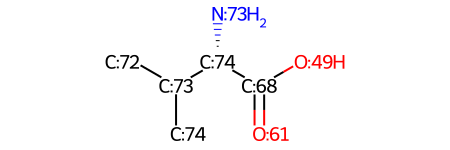

In [80]:
mol_with_atom_index(Chem.MolFromSmiles(aa_atom_dict['v']), amino_acid_atom_score[aa_dict['V']-1])

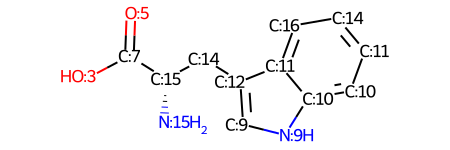

In [81]:
mol_with_atom_index(Chem.MolFromSmiles(aa_atom_dict['w']), amino_acid_atom_score[aa_dict['W']-1])

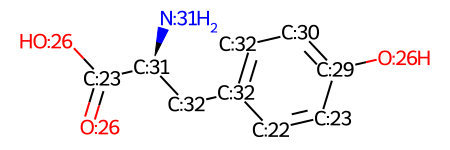

In [82]:
mol_with_atom_index(Chem.MolFromSmiles(aa_atom_dict['y']), amino_acid_atom_score[aa_dict['Y']-1])